# Labsheet 6: Odometry


This labsheet will cover reading the **Rotary Encoders** on your 3Pi+ robot, and then using this encoder data to maintain an estimate of the robot pose (position and rotation) on a 2D plane.  Tracking the robot pose is necessary to complete the coursework fully, as it will allow your robot to travel back to it's start position.  

In the next labsheet, we will utilise the rotary encoders for another purpose - for `closed-loop` control of the wheel speed.

In previous labsheets you will have:
- Familiarised with the Arduino IDE, Sketch files, uploading to the 3Pi+, and utilising the Serial interface
- Implemented basic operation of the 3Pi+ motors, and encapsulated this within safe and confident function(s), and utilised a `class`.
- Implemented basic read functionality of the 3 central IR Line sensors facing the work surface, and encapsulated this within function(s).
- Encapsulated the code for the line sensors within a `class`.
- Explored the use of `millis()` to approximate task-scheduling on the 3Pi+.
- Programmed a line following behaviour.
- Implemented a simple Finite State Machine, organising your code, and allowing you to easily manage what behaviours your robot is operating.  

In this labsheet you will:
- Validate correct operation of your rotary encoders.
- Implement kinematics.
- Validate and calibrate the odometry (pose estimation) of your 3Pi+.



<hr><br><br><br><br>

# Overview: Odometry

**`Odometry`** refers to maintaining an estimate of position using sensors.  The 3Pi+ has a rotary encoder per motor, which allows for the detection of rotation.  By using a last-known position and a subsequent measurement of change, it is possible to calculate an estimate of the robot position.  This technique is known as **`dead reckoning`**.



In the last Labsheet "Line Following", you will have developed your first `closed-loop` control system.  Hopefully, your robot was able to follow the line sufficiently well.  This would mean your robot appeared to have an intelligent autonomous behaviour.  It is important to recognise that to achieve this, your robot was utilising a `source of information` from the environment - the line.

<p align="center">
<img width="75%" src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_InfoSource.png?raw=true">
</p>

However, despite the intelligent looking behaviour whilst line following, the robot had no idea where it was, or how far it had travelled.  In this labsheet, we will focus on generating more information for your robotic system to later utilise. In other parts of the line following challenge, relying on line following is no longer sufficient.  For instance:
- traversing the gap in the line.
- determining the end of the line.
- returning to home (start position).

If we can utilise the rotary encoders to estimate the robot position, we can use this information to perform operations such as:
- turn to a specific angle
- move to a specific location
- maintain a straight course of travel
- estimate the distance travelled
- etc.


<hr><br><br><br><br>

# Encoders

The 3Pi+ has a sensor subsystem called a `rotary encoder`, one attached to each motor.   The rotary encoder is able to indicate when rotation has occured.  Some rotary coders are `absolute`, meaning they can be read to know the exact rotation of the device they are attached to.  Other encoders are `incremental`, meaning that when read they only indicate a change in rotation.  It is also possible to get position encoders which measure linear travel, rather than rotation.  

There are two principle ways to read an encoder:
- **`polling`**: if a device is polled, it means the device is read at regular time intervals.  This would mean the encoder is read whether or not there was any rotation.  It is important that the read operation happens sufficiently frequently or many rotations may happen (and be missed) within the time interval.  The `polling` technique will be demonstrated and discussed as insufficient in one of the unit lectures.
- **`interrupt-driven`**: in an interrupt driven subsystem the host computer can set peripheral hardware to monitor for a change.  When a change occurs, an `interrupt` flag (request) is set, and an `interrupt service routine` (ISR) within the microcontroller is required to handle the information within an appropriate time frame.

The 3Pi+ 32u4 microcontroller is able to configure peripheral hardware to monitor for status changes on some of the `gpio` pins. Thus, every time an encoder is moved, it will trigger the `interrupt service routine` (ISR).  The ISR code can be written to effectively keep a count of how many times a rotation has occured.  The ISR will also register whether it was a forwards or backwards movement, to increment or decrement the count respectively:

<p align="center">
<br>
<img width="50%" src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_EncoderCount.png?raw=true">
<br>
</p>

## Exercise 1: 3Pi+ Encoders

1. Does the 3Pi+ have `absolute` or `incremental` rotary encoders?  (documentation <a href="https://www.pololu.com/docs/0J83/5.4">1</a>, <a href="https://www.pololu.com/product/3081">2</a>)

2. **Hypothesise (Task):** We could say that the encoders detect the rotation of either the motors (`actuators`), or the wheels (`effectors`).  Which of these (motors or wheels) is the more important description of the nature of the information the 3Pi+ will be able to sense?

3. **Hypothesise (Hardware):** The designers of the 3Pi+ attached the encoders to the motors prior to the reduction gearbox.  
  - What is an advantage of this design choice?  
  - What is a disadvantage of this design choice?


<hr><br><br><br><br>

# Quadrature Encoding

For this section we will consider only 1 encoder, which has 2 `hall effect` sensors (`transducers`), and 1 magnet.

<p align="center">
<br>
<img width="75%" src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_EncoderAssembly.png?raw=true">
<br>
</p>

When the wheel is rotated, the magnet is rotated, and so a magnetic field moves over the sensor circuit.  The two `Hall effect` sensors alter their output in response to the magnetic field, and so two signals are generated.  The state of a `Hall effect` sensor signal can be interpretted as a logic signal by comparing it to be above or below a threshold voltage.  Because there are two `Hall effect` sensors, the combination of two logic signals (either `0` or `1`) provide 4 possible states (base two, two signals: $2^2$), hence the name `quadrature` encoders.

The two logic signals are typically referred to as **Channel A** and **Channel B**.  Importantly, the **relationship** between these two signals is defined by their physical placement on the sensor circuit.  The relationship between Channel A and B will inform the measurement of rotation.
> "What is meant by relationship?"

Here, the relationship of the two signal means `how they change with respect to one another`.  If they were `independent` variables, it would mean there was no relationship at all, and they could vary independently.  In the case of this rotary encoder, both of the `Hall effect` sensors are exposed to the same varying magnetic field, and both of their positions relative to the field are fixed by the construction of the circuit board.  This means that the Channel A and Channel B signals can be understood to vary relative to one another.  If we were to change the magnet placement, or introduce an interferring signal, the relationship between Channel A and B would no longer be true.

<p align="center">
<br>
<img width="75%" src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_HallEffect90.png?raw=true">
<br>
</p>

The graphic above is for a <a href="https://www.pololu.com/product/3081">similar sensor circuit</a> as built into the 3Pi+ encoder subsystem.  The graphic has been annotated to indicate where the `rear motor shaft` is located, which is the point of rotation of the magnet.  The two `Hall effect` sensors are annotated, and their position is marked to show that they sit at approximately 90&deg; to one another with respect to the origin of the rotating magnetic field.  This means that their measurement of the magnetic field will **always** be 90&deg; out of phase (out of synchrony, or shifted, by a quarter cycle).  We will explore this idea further:

<p align="center">
<br>
<img src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_90Phase.png?raw=true">
<br>
</p>

The above diagram illustates how the magnetic field (north and south poles, red and blue respectively) will move over the two `Hall effect` sensors.  A small red dot has been added to help indicate how the field is rotating across the four states in time, read left to right respectively.  In reality, the magnet will move continuously, but these are the essential 4 states registered by the encoder subsystem.

The logic signals for Channel A and B are visible above as  the `square waveforms`, and coloured to match the magnetic field polarity detected in each state.  These waveforms will endlessly repeat their high-low-high transitions as the magnet is rotated above them.  Notice that, if we mark in time where each Channel transitions to logic `1` (or high), we can see they are 90&deg; out of phase with respect to each other.

|Channel B   | Channel A   |
|:---:|:---:|
| 0  | 0  |
| 0  | 1  |
| 1  | 1  |
| 1  | 0  |

We can examine the above diagram and produce the above logic table, where south-polarity (blue) is logic 0, and north-polarity (red) is logic 1.  These are the 4 possible states of the `hall effect` sensors combined.  If the magnet continues rotating in the same direction as the illustration, this logic table would repeat itself.  At this point, we could be satisfied by registering a logic change, to keep a "count" of how many times the encoder has detected a rotation.  However, we know that the wheels of the 3Pi+ can be rotated in either direction - and so we need to know in what direction the change occured.

<p align="center">
<br>
<img src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_EncoderXORSignals.png?raw=true">
<br>
</p>

It is therefore important to register the `logic transitions` in the signals.  In the above illustration, the transitions of the waveforms have been annotated in green.  Note:
- the transitioning logic (green text) has an arrow next to it - this is because the progression of these waveforms could be read left-to-right, or right-to-left, depending on which way the wheel is rotating.  
- We will use the logic of this direction information later in "Example Encoder Code".
- a transition occurs only when the other channel is in a stable logic condition (either high or low).  

We could therefore formulate some logic like:
> If `A is LOW`, and `B goes LOW to HIGH`, rotation equals `<--`

> If `A is LOW`, and `B goes HIGH to LOW`, rotation equals `-->`

In order to capture a transition from low-to-high, or high-to-low, it is necessary to have `prior` information (what was the state of the channel before?):

<p align="center">
<br>
<img src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_EncoderDirection.png?raw=true">
<br>
</p>

In the above illustration, the `prior` state of the encoder is marked in red, as `A = 1, B = 1`.  Our code would then need to work out if it is either **channel A** which changes, or **channel B** which changes, away from the prior state.  We will resume this discussion of detecting logical changes in the section "Example Encoder Code".  This "direction" of this transition away from the prior state will allow our robot to count up or down with respect to the direction of travel:

<p align="center">
<br>
<img width="50%" src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_EncoderCount.png?raw=true">
<br>
</p>

This discussion will continue after we have taken a closer look at how the 3Pi+ can be configured to detect these logic level changes with `pin change interrupts`.





<hr><br><br><br><br>

# Pin Change Interrupts

In the previous section, we have discussed how the 3Pi+ can determine direction of rotation by registering the transition of the A and B channels of the encoder.  We have used the assumption that an encoder `interrupt service routine` (ISR) will activate when the wheel is moved.  This is achieved on the 3Pi+ by using a **`Pin Change Interrupt`**.  

**`Pin Change Interrupts`** are a special piece of hardware.  Microcontrollers have many useful built-in peripherals.  A pin change interrupt watches a specific pin on the chip for a change of state (low to high, or high to low).  When the microcontroller detects a change, it can be set to automatically run a piece of code.  The piece of code which runs automatically is called an **`Interrupt Service Routine`** (ISR).  An ISR is not exclusively for pin changes - they can be triggered to run by many peripherals, taking input internal or external to the microcontroller.  

An `interrupt` is so called because it will pause sequence of your main code.  These are especially useful to catch external events, rather than inefficiently `polling` to detect them.  However, most microcontrollers have only one central processing unit (CPU, often called a 'core').  Therefore, because your code within `loop()` runs on the only CPU inside the 32u4, it will be paused to run an ISR instead.  

You can think of an ISR as being a background task which runs "only when it needs to".  However, you are responsible for determining the cause of the interrupt (what triggers it), and the efficiency of the ISR (how much CPU time it will use).  

> As a general rule, code within ISR's should be as short as possible in order to avoid taking up too much CPU time.

If you are experimenting with an ISR and your robot starts to behave in a strange way, you may have made your ISR too big (or more seriously, have a bug within the ISR code).  Note that, using ISR's means the execution of your code is no longer `deterministic` - the compiler cannot predict when an ISR will activate, and neither can you.  For example, we cannot know when a wheel and motor will rotate.  

Obviously, a Pin Change Interrupt is very convenient for watching the state of the encoders.  We can consider catching encoder changes to be a high priority, perhaps higher than our main program.  For example, if we miss encoder changes, we will not know if the wheels have rotated, and so error will be introduced into any calculation of the robot position.  

## A Slight Complication

**This section has further detail which is not essential for the exercises in this labsheet.** However, it is a relevant matter of interest for future careers in robotics.  Whichever your individual specialism, it is highly likely you will need to be able to hold a conversation into other subject domains with your colleagues and team members.  In this section, we will review some electronic decisions made by the designer (Pololu) of the 3PI+, and their impact on the software development.  

A limitation is that only specific pins can be monitored by a Pin Change Interrupt, and there are a finite number of pins to use.  The 3Pi+ has two encoders, each with two pins.  This means that in an ideal world we might like to watch 4 independent pin changes in total.  

The designers of 3Pi+ decided to use some electronics to use monitor just 1 microcontroller pin per encoder to trigger a pin change interrupt - using just one pin to register a change for either Channel A or B of an encoder.  They have achieved this by using an electronic XOR (eXclusive OR) logic gate across the A and B channels.  

<p align="center">
<img src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_XOR_Schematic.png?raw=true">
</p>

The implementation of this electronic XOR gate is visible in the above extract from the <a href="https://www.pololu.com/file/0J1790/3pi-plus-32u4-control-board-schematic.pdf">3Pi+ electronic schematics</a>.  Channel A and B are labelled as `ELA` and `ELB` (here, Encoder Left A, Encoder Left B).  The labels `PE2` and `D8` are the input pins to the 32u4 microcontroller.

Recall that the signals for A and B are always out of phase by 90&deg;.  We also drew out a logic table of how the A and B logic signals progress with rotation:

|Channel A   | Channel B   |  Electronic XOR  |
|:---:|:---:|:---:|
| 0  | 0  | 0 |
| 0  | 1  | 1 |
| 1  | 1  | 0 |
| 1  | 0  | 1 |

In the above table, we can see that the XOR resultant logic always transitions low-high-low-high, and this change can be caught by the pin-change interrupt.  However, once the pin change causes an interrupt, it is necessary to then work out what the state of Channel A must be, which has not been read directly.  

|Channel A   || Channel B  |  Electronic XOR  |  Software XOR (B^E-XOR) |
|:---:||:---:|:---:|:---:|
| 0  |-| 0  | 0 |  0 |
| 0  |-| 1  | 1 |  0 |
| 1  |-| 1  | 0 |  1 |
| 1  |-| 0  | 1 |  1 |

In the above table, a fourth column is added which is the logical XOR of the `electronic XOR` and `Channel B`.  It can be observed that the result (Software XOR) is identical to the state of Channel A, which was unknown.  

In code, this second XOR operation is completed in software.  The whole process resembles the following:

- Electronic XOR transition causes `interrupt service routine` (pin change ISR).
- ISR code reads electronic XOR state, and reads Channel B state.
- ISR code performs software XOR between `electronic XOR` and `channel B` states.
  - Software XOR result is Channel A state.

You can find more information in the <a href="https://www.pololu.com/docs/0J83/5.4">documentation</a>.

**For now, you don't need to fully understand this operation - it is a matter of interest**. In the following section of code within our ISRs to perform this XOR and restore the A and B pin states.  It looks a little strange - **but don't worry, it is complete and you do not need to modify it:**

```c
  // We know that the ISR is only called when a pin changes.
  // We also know only 1 pin can change at a time.
  // The XOR(AB) signal change from "Channel A" triggers ISR.
  
  // First, Read in the new state of the encoder pins.
  // Standard pins, so standard read functions.
  boolean e0_B = digitalRead( E0_B_PIN ); // normal B state
  boolean e0_A = digitalRead( E0_A_PIN ); // XOR(AB)

  // Software XOR (^) logically infers
  // the true value of A given the state of B
  e0_A = e0_A ^ e0_B;
```
**You can just assume the above XOR operation works, and simply make sure you do not delete it from the template code provided.**





<hr><br><br><br><br>

# Setting Up Pin Change Interrupts

Configuring the microcontroller hardware to use the Pin Change Interrupts is a little bit complicated, so we have done this for you.  We will discuss register operations and bitwise operators within the lecture series.  You can find the following encoder setup code within `encoders.h` of the Arduino code template on Github (<a href="https://github.com/paulodowd/EMATM0054_53_23-24/tree/main/3PI_CodeStub">page</a>, <a href="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/3PI_CodeStub/Labsheet_X.zip">Zip file</a>).  For further information you can look at the two functions:
- **setupEncoder0()**
- **setupEncoder1()**

These set up Pin Change Interrupts for the two encoders on the  3Pi+.  Both functions are heavily commented.  Both involve bitwise operations to registers within the microcontroller.  Setting bits in registers activates peripherals or configures the microcontroller.  If you'd like to experiment with similar operations, it is recommended you look at the labsheet concerning the Timer peripheral.  

```c
void setup() {

  //...
  // Setup encoders when the robot is
  // powered on.
  setupEncoder0();
  setupEncoder1();

  //...

}

void loop() {

  // ...
}

```


<hr><br><br><br><br>

# The Two Interrupt Service Routines (ISRs)

An ISR is written to service an event from a particular peripheral.  This is achieved by using a special function declaration, which attaches to the source of the interrupt (a good start for further reading is available <a href="https://en.wikipedia.org/wiki/Interrupt_vector_table">here</a>).  In our case, we are using pins which carry the definition `INT6_vect` and `PCINT0_vect`, there are where the encoders have been wired too on the 3Pi+ (<a href="https://www.pololu.com/docs/0J83/5.9">documentation</a>) - and which we can find are Pin Change enabled in the 32u4 microcontroller manual (<a href="https://ww1.microchip.com/downloads/en/DeviceDoc/Atmel-7766-8-bit-AVR-ATmega16U4-32U4_Datasheet.pdf">documentation</a>).  

You'll find these details referenced in the setup routines setupEncoder0() and setupEncoder1(). You can find this code within `encoders.h` of the Arduino code template on Github (<a href="https://github.com/paulodowd/EMATM0054_53_23-24/tree/main/3PI_CodeStub">page</a>, <a href="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/3PI_CodeStub/Labsheet_X.zip">Zip file</a>).  Our ISR function declarations look like:

```c
ISR( INT6_vect ) {
 // ....
 // ...ISR code - keep it short!...
 // ...A basic template is provided for you.
 // ....
}
ISR( PCINT0_vect ) {
 // ....
 // ...ISR code - keep it short!...
 // ...A basic template is provided for you.
 // ....
}
```

After calling the `setupEncoder0()` and `setupEncoder1()` inside `setup()`, these two ISR functions will execute whenever the encoder changes state.  
> Therefore, you never need to call `ISR( ... )` explicitly.

Note that the functions cannot take any arguments or provide any return type.  

To have any persistent data, these ISR's will have to operate on `global` variables.  Because we don't know when the ISR's will execute (e.g., we cannot predict when the wheel will rotate), we also need to declare the associated global variables as `volatile`.   Volatile is a keyword to the compiler, informing the compiler not to use any cache based optimatisations.  Therefore, in global scope, we declare the following global variables to be used by our ISR functions:

```c
// Volatile Global variables used by Encoder ISR.
volatile long count_e1; // used by encoder to count the rotation
volatile byte state_e1; // used to store the prior and current state.

volatile long count_e0; // used by encoder to count the rotation
volatile byte state_e0; // used to store the prior and current state
```

For the remaining implementation details for the Pin Change Interrupt ISR's, you can read the comments provided in the example code.



<hr><br><br><br><br>

# Example Encoder Code

Now that we understand the logical operation of the encoders, and we understand that they will be read by interrupt service routines, it is time to take a closer look at code.  The Arduino code template on Github (<a href="https://github.com/paulodowd/EMATM0054_53_23-24/tree/main/3PI_CodeStub">page</a>, <a href="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/3PI_CodeStub/Labsheet_X.zip">Zip file</a>) provides template functions within  `encoders.h` which you will need to complete.  This section discusses how the code within `encoders.h` will operate.

## Decoding Encoders

From previous sections we know that:
- the ISR will activate when either Channel A or Channel B changes state.
- we can read and decode the correct current state of A and B when the ISR is activated.
- we need to register which channel has changed to infer the `direction` of change.
- therefore, we need the prior state and the current state of the encoder.

We can consider that the system needs to maintain 4-bits of information:
- The `prior` states $(t-1)$ of Channel A (0/1) and B (0/1)
- The `current` states $(t)$ of Channel A (0/1) and B (0/1)

Because the states of A and B are boolean logic, the theoretical number of possible combinations is $2^4$, or 16 possible states.

|Index| Channel B (t)  | Channel A (t)  |-| Channel B (t-1)  | Channel A (t-1)  | Notes  |
|:---:|:---:|:---:|-|:---:|:---:|:---|
| 0 | 0  | 0  |-|  0 |  0 |  (no change, invalid) |
| 1 | 0  | 0  |-|  0 | 1  |   |
| 2 | 0  | 0  |-|  1 |  0 |  |
| 3 | 0  | 0  |-|  1 |  1 | (change x2, invalid) |
| 4 | 0  | 1  |-|  0 |  0 |  |
| 5 | 0  | 1  |-|  0 |  1 | (no change, invalid)|
| 6 | 0  | 1  |-|  1 |  0 | (change x2, invalid) |
| 7 | 0  | 1  |-|  1 |  1 |  |
| 8 | 1  | 0  |-|  0 |  0 |  |
| 9 | 1  | 0  |-|  0 |  1 |  (change x2, invalid)|
| 10 | 1  | 0  |-|  1 |  0 |  (no change, invalid)|
| 11 | 1  | 0  |-|  1 |  1 |  |
| 12 | 1  | 1  |-|  0 |  0 |  (change x2, invalid)|
| 13 | 1  | 1  |-|  0 |  1 |  |
| 14 | 1  | 1  |-|  1 |  0 |  |
| 15 | 1  | 1  |-|  1 |  1 | (no change, invalid) |

The above logic table illustrates all the theoretical states of the encoders.  From our prior undestanding of the encoder operation, we can invalidate several possible states immediately, as annotated above.  This leaves 8 entries in the table as valid.

|Index| Channel B (t)  | Channel A (t)  |-| Channel B (t-1)  | Channel A (t-1)  | Notes  |
|:---:|:---:|:---:|-|:---:|:---:|:---|
| 0 | 0  | 0  |-|  0 |  0 |  (no change, invalid) |
| 1 | 0  | 0  |-|  0 | 1  |  +1 |
| 2 | 0  | 0  |-|  1 |  0 |  -1 |
| 3 | 0  | 0  |-|  1 |  1 | (change x2, invalid) |
| 4 | 0  | 1  |-|  0 |  0 | -1 |
| 5 | 0  | 1  |-|  0 |  1 | (no change, invalid)|
| 6 | 0  | 1  |-|  1 |  0 | (change x2, invalid) |
| 7 | 0  | 1  |-|  1 |  1 | +1 |
| 8 | 1  | 0  |-|  0 |  0 | +1 |
| 9 | 1  | 0  |-|  0 |  1 |  (change x2, invalid)|
| 10 | 1  | 0  |-|  1 |  0 |  (no change, invalid)|
| 11 | 1  | 0  |-|  1 |  1 | -1 |
| 12 | 1  | 1  |-|  0 |  0 |  (change x2, invalid)|
| 13 | 1  | 1  |-|  0 |  1 | -1 |
| 14 | 1  | 1  |-|  1 |  0 | +1 |
| 15 | 1  | 1  |-|  1 |  1 | (no change, invalid) |

We can use the logic as presented in <a href="https://github.com/paulodowd/EMATM0054_22-23/blob/main/images/3PI_EncoderDirection.png?raw=true">this illustration</a> to complete the table above with a direction of rotation.  In the table above, `+` or `-` are used to indicate direction.  Whether this corresponds to forwards or backwards motion of your 3Pi+ will need to be `empirically` validated.

If we look at the table above, we can imagine writing an if(){} statement to select the appropriate table row given our encoder states, something like:

```c
    if( (old_b == 1) && (old_a == 0) && (new_b == 0) && (new_a == 0) ) {        // Row 1
        
    } else if( (old_b == 0) && (old_a == 1) && (new_b == 0) && (new_a == 0) ) { // Row 2
        
    } else if( ... ) { // ... etc

```
However, this is very long winded, and we will need to maintain lots of different variables.


If we consider the table above, we can see that the valid entries have the index values: `1`, `2`, `4`, `7`, `8`, `11`, `13` and `14`.  These values are not assigned randomly or by chance.  In fact, if we relabelled the columns of the table with bitwise magnitude values, it becomes apparent the `index` is the decimal value of the columns as binary representation:

|Decimal| 8:  Channel B (t)  | 4: Channel A (t)  |-| 2: Channel B (t-1)  | 1: Channel A (t-1)  | Notes  |
|:---:|:---:|:---:|-|:---:|:---:|:---|
| 0 | 0  | 0  |-|  0 |  0 |  (no change, invalid) |
| 1 | 0  | 0  |-|  0 | 1  |  +1 |
| 2 | 0  | 0  |-|  1 |  0 |  -1 |
| 3 | 0  | 0  |-|  1 |  1 | (change x2, invalid) |
| 4 | 0  | 1  |-|  0 |  0 | -1 |
| 5 | 0  | 1  |-|  0 |  1 | (no change, invalid)|
| 6 | 0  | 1  |-|  1 |  0 | (change x2, invalid) |
| 7 | 0  | 1  |-|  1 |  1 | +1 |
| 8 | 1  | 0  |-|  0 |  0 | +1 |
| 9 | 1  | 0  |-|  0 |  1 |  (change x2, invalid)|
| 10 | 1  | 0  |-|  1 |  0 |  (no change, invalid)|
| 11 | 1  | 0  |-|  1 |  1 | -1 |
| 12 | 1  | 1  |-|  0 |  0 |  (change x2, invalid)|
| 13 | 1  | 1  |-|  0 |  1 | -1 |
| 14 | 1  | 1  |-|  1 |  0 | +1 |
| 15 | 1  | 1  |-|  1 |  1 | (no change, invalid) |

We can then write an `if()` statement to check the decimal value, knowing it corresponds to a pair of `prior state` and `current state` of the encoder.  

```c
if( state_e0 == 1 ) {
  count_e0 = count_e0 + 1;  // forwards

} else if( state_e0 == 2 ) {
  count_e0 = count_e0 -1;   // backwards

} else if () { //...etc
```

The task at hand therefore becomes storing the `prior state` and `current state` information in a binary format to read as a decimal value from a single variable.  You may have noticed earlier we declared a variable of datatype `volatile byte` called `state_e0`:

```c

volatile long count_e0; // used by encoder to count the rotation
volatile byte state_e0; // used to store the prior and current state

//...

void setupEncoder0() {

    // Setup pins for encoder 0
    pinMode( ENCODER_0_A_PIN, INPUT );
    pinMode( ENCODER_0_B_PIN, INPUT );

    // initialise the recorded state of e0 encoder.
    state_e0 = 0;

    // Get initial state of encoder pins A + B
    boolean e0_A = digitalRead( ENCODER_0_A_PIN );
    boolean e0_B = digitalRead( ENCODER_0_B_PIN );
    e0_A = e0_A ^ e0_B;

    // Shift values into correct place in state.
    // Bits 1 and 0  are prior states.
    state_e0 = state_e0 | ( e0_B << 1 );
    state_e0 = state_e0 | ( e0_A << 0 );

    // ...
}

```

In the above `setupEncoder0()` routine we can observe how the initial states of the A and B channels are read and stored into bits 0 and 1 of the variable `state_e0`.  The `setupEncoder0()` and `setupEncoder1()` functions should be run when your robot first activates, before any motion.   In this line:

```c
state_e0 = state_e0 | ( e0_B << 1 );
```

The value `e0_B` is being shifted once to the left (`<< 1`), and then logically OR'd (`|`) into the existing value of state_e0.  We can think of this as moving the boolean value of `e0_B` into column 1 of the table.  For more information on how this is working, it is recommended to review bitwise operators (<a href="https://www.arduino.cc/reference/tr/language/structure/bitwise-operators/bitwiseand/">Arduino Reference</a>).  



We can then review the ISR function for encoder 0:

```c

// This ISR handles just Encoder 0
// ISR to read the Encoder0 Channel A and B pins
// and then look up based on  transition what kind of
// rotation must have occured.
ISR( INT6_vect )
  // We know that the ISR is only called when a pin changes.
  // We also know only 1 pin can change at a time.
  // The XOR(AB) signal change from "Channel A" triggers ISR.

  // First, Read in the new state of the encoder pins.
  // Standard pins, so standard read functions.
  boolean e0_B = digitalRead( E0_B_PIN ); // normal B state
  boolean e0_A = digitalRead( E0_A_PIN ); // XOR(AB)

  // Software XOR (^) logically infers
  // the true value of A given the state of B
  e0_A = e0_A ^ e0_B;

  // Shift our (new) current readings into bit positions
  // 2 and 3 in the state variable (current state)
  // State: (bit3)  (bit2)  (bit1)   (bit0)
  // State:  new B   new A   old B   old A
  state_e0 = state_e0 | ( e0_B  << 3 );
  state_e0 = state_e0 | ( e0_A  << 2 );

  // Handle which transition is registered:
  if( state_e0 == 2 ) {
  // ...
  // (large segment of code cut)
  // ...

  // Shift the current readings (bits 3 and 2) down
  // into position 1 and 0 (to become prior readings)
  // This bumps bits 1 and 0 off to the right, "deleting"
  // them for the next ISR call.  
  state_e0 = state_e0 >> 2;
}

```




Everytime the motor physically rotates, it will generate a new transition on the encoder.  Typically, encoders refer to this property as **Count Per Revolution (CPR)**, **Pulses Per Revolution (PPR)** or **Lines Per Revolution (LPR)**.  The higher the CPR, the more precisely  rotation can be determined. This is because we are essentially dividing a full rotation (360 degrees, or 2\*PI radians) by the CPR.  One thing that will effect this, is whether the encoder is placed before or after any gearing on the motor.  It may be that a full rotation of the encoder is only a fraction of a full rotation of the wheel.  You can find the gear ratio for the 3Pi+ in <a href="https://www.pololu.com/docs/0J83/5.4">the documentation</a>.  Remember that we are using the Standard Kit (not the Turtle or Hyper edition).  


## Exercise 2: Complete the Encoder ISRs

In this exercise you will need to update the `encoders.h` source file so that the code operates correctly.  After previous labsheets, you might be inclined to refactor into a `class`.  However, this code has special function calls to operate `interrupt service routines`, and so it is not suitable for a `class` implementation.  

1. Given we are using the datatype `long` to store the encoder counts, what is the maximum and minimum values that can be stored?

2. **Hypothesise (software):** When we update the byte variables `state_e1` and `state_e0` to move `current state` into `prior state` at the end of the ISR, we shift to the right `>>`.  We could imagine writing the whole ISR operation to shift `current state` into `prior state` to the left (`<<`) instead.  What would be the problem with this?  

3. Review and update the template provided for you in `encoders.h`:
  - You do not need to change anything in `setupEncoder0()` or `setupEncoder1()`.
  - **Decompose the problem:** Work on one encoder ISR to start with.  Once you have one encoder ISR working, work to complete the second encoder.  
  - Complete the ISR `if()` statement to properly increment and decrement the count value.  
    - Many required conditional statements are missing.
    - You can refer to the tables presented above for assistance.
  - **Validate:** Ensure that you increment and decrement `count_e0` and `count_e1` within the correct ISR routines.
    - A common error is that one ISR is updating the other's count.

  - **Validate:** Use `Serial.print` within `loop()` to check that your encoder values can consistently go up and down, with forward and backward motion.
    - Ensure you add the function calls `setupEncoder0()` and `setupEncoder1()` to your `setup()` routine, otherwise the ISRs won't work.
    - Should forward motion increment values, or decrement values?  There is no correct answer to this question.  Please decide for your implementation.
    - How many encoder counts do you register for a full rotation of a wheel?
      - Is this what you expect?
      - How close is this to the theoretical answer? (<a href="https://www.pololu.com/docs/0J83/5.4">documentation available here</a>).
      - How might you improve your measurement of total encoder counts for a full rotation of a wheel?
      - It is possible that your encoders may deviate from the theoretical number of counts per revolution - what factors might cause this?
      - Given the total encoder counts per revolution of the wheel, what is the angular resolution of 1 encoder count?
      - Given the dimensions of the wheel, how much distance is travelled by the wheel for 1 encoder count?
  - **Refactor:** The functions and variables have been consistently named `e0` and `e1`:
    - determine which is left and right.
    - consider updating the code to rename e0 and e1 to left/right, or l/r, as appropriate.
    - why might this be useful to do?

<hr><br><br><br><br>

# Kinematics

At this point the 3Pi+ should be reliably counting the number of encoder pulses as the wheel rotates.  You may also have attempted to translate this information into the distance travelled by each wheel respectively.  However, tracking the distance travelled by an individual wheel is insufficient to estimate the robot position in the `task environment`.

In this section, we will implement a simple kinematic model for the 3Pi+ robot.  This will integrate the contribution of both the left wheel and right wheel to estimate a resultant `pose` of the robot.  In terms of our **`task`**, it would be useful to know:
- the X position of the robot in the `task environment`.
- the Y position of the robot in the `task environment`.
- the rotation of the robot in the `task environment`.

<p align="center">
<img src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/3PI_KinematicsOverview.png?raw=true">
</p>

As the robot travels, we will estimate it's position within a `global co-ordinate frame` annotated $X_{I}$, $Y_{I}$. In our task, it is convenient to set the origin of the `global co-ordinate frame` ($X_{I}=0$, $Y_{I}=0$) when the robot is powered on.  Therefore, where your robot is positioned when it is powered on (or reset) will become the origin of it's subsequent position estimations.

Creating a `local co-ordinate frame`, annotated as $X_{R}$, $Y_{R}$, allows us to describe the `configuration` of wheels relative to the robot centre at point $p$.  For our robot, the chassis holds two wheels in a fixed relation (e.g., they are fixed on either side of the robot, and cannot be repositioned).  We assume:
- the robot also has wheels of the same size, radius $r$.  
- the wheels are configured at a distance $l$ and rotated +/- 90&deg; ($\pi/2$) respectively from $X_{R}$. This aligns the direction of travel of both wheels with $X_{R}$.  


We then address the central question of how the rotation velocity of the left and right wheels, $\phi_{l}$ and $\phi_{r}$, will displace the robot within the local frame:

> $\dot{X_{R}} = \frac{r\phi_{l}}{2} + \frac{r\phi_{r}}{2} $
<br> the contribution along $X_{R}$, which we understood as each wheel contributing to half the forward motion of the robot at point $p$.

> $\dot{Y_{R}} = 0$
<br> the contribution along $Y_{R}$, which we understood as being zero contribution because the wheels are aligned to $X_{R}$ and unable to slide.

> $\dot{\theta_{R}} = \frac{r\phi_{l}}{2 l} - \frac{r\phi_{r}}{2 l}$
<br>the contribution of rotation, which we understood to describe the counter-active motion of each wheel, if any, proportional to their distance of separation $2l$.  

In the above, you will notice the terms $r\phi_{l}$ and $r\phi_{r}$.  These can be read as:
> _for left or right, wheel radius multiplied by angular rate_

If we multiply the radius by the angular rate, **we calculate the distance travelled for some timestep**.  When working with the 3Pi+, we have this information (the distance travelled in a timestep) implicitly as the **difference in encoder count** between calls to our kinematic update routine.  Therefore, it would be inefficient to calcuate wheel speed in one area of your code, and then resolve speed back to distance in your kinematic update.  

In effect you have a choice between updating your kinematics with an estimated wheel speed, or with the difference in encoder counts.  If you use wheel speed, you will need to incorporate the difference in time between your kinematic updates to resolve back to a distance.  Ultimately, you want to determine a distance travelled for each wheel, to then use when calucating $\dot{X_{R}}$ and $\dot{\theta_{R}}$.

The above contributions, $\dot{X_{R}}$ and $\dot{Y_{R}}$, are in the local co-ordinate frame.  Therefore, each component will have a magnitude relative to the local origin.  To utilise these as a displacement in the global co-ordinate frame, they require rotating and translating with respect to the prior pose of the robot.  Rotation is achieved via an `orthogonal rotation matrix` using $\theta_{I}$.  

In our simple kinematic model, $\dot{Y_{R}}$ is always 0.  Therefore, the following matrix (left side) is simplifies to the equations on the right side:

<p align="center">
<img width="50%" src="https://github.com/paulodowd/EMATM0054_53_23-24/blob/main/Images/kinematic_update.png?raw=true">
</p>

Including the translation, our update calculation at each time step $t$ is therefore:
<br>
<p align="center">
$X_{I}^{\;t+1} = X_{I}^{\;t} + ( \;\dot{X_{R}} \; cos \; \theta_{I}^{\;t}\; )$
</p>

<p align="center">
$Y_{I}^{\;t+1} = Y_{I}^{\;t} + (\;\dot{X_{R}}\; sin \;\theta_{I}^{\;t}\; )$
</p>

<p align="center">
$\theta_{I}^{\;t+1} = \theta_{I}^{\;t} + \dot{\theta_{R}}$
</p>






<hr><br><br><br><br>

## Exercise 3: Implement Kinematics

1. Review and update the `class` within `kinematics.h` source file of the 3Pi+ Arduino template available via Github (<a href="https://github.com/paulodowd/EMATM0054_53_23-24/tree/main/3PI_CodeStub">Github Page</a>, <a href="https://github.com/paulodowd/EMATM0054_53_23-24/raw/main/3PI_CodeStub/Labsheet_X.zip">Download Link for Zip file</a>), or create your own.  In this first exercise, aim to get a reasonable but not perfect level of performance.  Your main goal should be to ensure there are no bugs in your code.
  - You may wish to implement the kinematics within `loop()` until you feel confident it is working, before working within the `class` construct.
  - For estimating position, it is not necessary to attempt to update position with every change to the encoder count.  Instead, decide a reasonable and regular time interval to perform your kinematic update.  
  - Your code will need to know the change in encoder counts since the last time the kinematics was updated.  Create variables to store and update this information.  
    - Start your kinematic update function by ensuring you can register and update a change of encoder counts.
    - Remember to pay attention to variable `data types` and potential bugs.
  - In a previous exercise, you will have calculated some useful information:
    - the total number of encoder counts per revolution.
    - the mm of travel per encoder count.
  - Use either the measurements of the 3Pi+ provided in the <a href="https://www.pololu.com/docs/0J83">documentation</a>, or take your own measurements of $l$ and $r$.  
  - Start by implementing only the $X$ contribution:
    - **Validate:** Moving the robot backwards and forwards (no rotation), check that the values reported for a full rotation of both left and right wheels together appears correct.
    - Moving the robot slowly by hand (no battery power) will likely make this easier.
    - Select a distance, such as 100mm, to validate your kinematics.
  - Imlpement the $\theta$ contribution:
    - When working on $\theta$, test your robot without any translation motion (forwards/backwards).
    - **Validate:** place your robot on a surface with a known angle marked out.  This could be 90&deg;, or a small chart of angles (plenty are available via a <a href="https://www.google.com/search?q=radians+angles&tbm=isch&ved=2ahUKEwjopoDK5ZfzAhUP_RoKHcq5BVYQ2-cCegQIABAA&oq=radians+angles&gs_lcp=CgNpbWcQAzIFCAAQgAQyBQgAEIAEMgYIABAIEB4yBggAEAgQHjIGCAAQCBAeMgYIABAIEB4yBggAEAgQHjIGCAAQCBAeMgYIABAIEB4yBggAEAgQHjoHCCMQ7wMQJzoECAAQQzoGCAAQBRAeUKbLBFiJ1gRg3NYEaABwAHgAgAE6iAGVA5IBATiYAQCgAQGqAQtnd3Mtd2l6LWltZ8ABAQ&sclient=img&ei=_NxNYei4L4_6a8rzlrAF&bih=937&biw=1920&rlz=1C1GCEB_enGB928GB928">Google Image search</a>).  
    - Move your robot by hand to check that it is calculating a good estimation of rotation.
    - **Validate:** Does $\theta$ increment and decrement clockwise and anti-clockwise as you would expect?  



<hr><br><br><br><br>

## Exercise 4: Improve Odometry

1. Look to improve your odometry.  It is recommended that you collect some data and practice graphing using a `boxplot` to evaluate performance.  A `boxplot` example has been provided below.

- Write some motor operation code so that your robot will drive forwards until it reaches a set distance.
  - For this exercise, do not use time to travel a distance.  Instead, write code to control motors via your global co-ordinate $X$ value.
  - **Evaluate:** Take measurments of your robot's stopping distance, both in terms of the internal measurement (odometry) and the external reality (`ground truth`).
    - Does your robot `overshoot` (stop late), or `undershoot` (stop early)?  
    - How is this visible on your boxplot?
    - Is this a problem with your motor control, or an error in kinematics?
    - In the procedure you have adopted to measure distance, how might you improve the precision and accuracy of your measurements, or your capability to record error?
  - **Hypothesise:** Given the form of the update equations, which parameter is most likely to effect the performance of the $X_{R}$ contribution?  
    - Adjust likely parameters to improve the performance, and repeat your evaluation.
    - Why might parameters deviate from the documented values?
  - **Note:** At this stage in the labsheets, your robot may still accrue some rotation during this forward/backward movement.  We will investigate how to control for this in the next labsheet covering PID.  

- Write some motor operation code so that your robot will rotate on the spot to a specific angle.
  - For this exercise, do not use time to perform a rotation.  Instead, write code to control motors via your global co-ordinate $\theta$ value.
  - **Evaluate:** Perform similar evaluations as the above.  Take a number of measurements to `characterise` the performance of your robot.
    - In the procedure you have adopted to measure distance, how might you improve the precision and accuracy of your measurements, or your capability to record error?
  - **Hypothesise:** Make a similar hypothesis on which parameter most effects the $\theta$ contribution.  Explore parameters to see if you can improve the error when your robot rotates on the spot.

- Consider the observations you have made of translation and rotation movement for your robot.
 - **Hypothesise:** Which of these generates the more significant error in your odometry.  Discuss:
  - possible causes within your robotic system, across environment, hardware, software and task.
  - a rationale for why rotation or translation has the greater impact.

[Text(0, 0.5, 'Rotation Error (degrees)'),
 Text(0.5, 0, 'Implementation'),
 Text(0.5, 1.0, 'Fictional Results')]

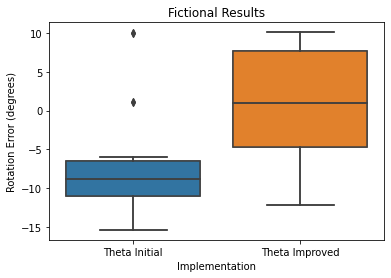

In [ ]:
#
# An example of using Python, Seaborn and
# Pandas to plot data into a Boxplot.

# We will use a library called Seaborn to
# make our box plot for us, so we import it.
import seaborn as sns


# To graph more than one dataset is a little
# complicated.  We need to format the
# data into 'dataframes'.  We use the pandas
# library to do this for us.  Import pandas:
import pandas as pd

# Add your measurements into the arrays
# like the following.
# Here, these are distance between the
# 3Pi+ center and the line center.
x_error_initial = [-9.1, -12.4, -8.6, -10.3, -15.4, -11.2, 10.0, -6.0, -8.1, 1.1]
x_error_improved = [-12.2, 10.1, 8.1, -8.2, 0.2, 8.5, -6.4, 6.2, 1.1, 0.8]

th_error_initial = [-9.1, -12.4, -8.6, -10.3, -15.4, -11.2, 10.0, -6.0, -8.1, 1.1]
th_error_improved = [-12.2, 10.1, 8.1, -8.2, 0.2, 8.5, -6.4, 6.2, 1.1, 0.8]

# You can make further arrays, following the
# pattern:
# pwm_60 = [ , , , ]

# We use the .DataFrame() function to apply a
# label to each array of results
x_initial_dataframe = pd.DataFrame({'X Initial':x_error_initial})
x_improved_dataframe = pd.DataFrame({'X Improved':x_error_improved})

th_initial_dataframe = pd.DataFrame({'Theta Initial':th_error_initial})
th_improved_dataframe = pd.DataFrame({'Theta Improved':th_error_improved})


# We then add the two dataframes together.
x_combined = pd.concat([ x_initial_dataframe, x_improved_dataframe], axis=0)

th_combined = pd.concat([ th_initial_dataframe, th_improved_dataframe], axis=0)

# We can now plot both datasets at the same time.
plot_x_error = sns.boxplot(data=x_combined)
plot_x_error.set(xlabel ="Implementation", ylabel = "Travel Error (mm)", title ='Fictional Results')

#plot_th_error = sns.boxplot(data=th_combined)
#plot_th_error.set(xlabel ="Implementation", ylabel = "Rotation Error (degrees)", title ='Fictional Results')

<hr><br><br><br><br>

## Exercise 5: Improve Kinematics

**For the line following challenge, the simple kinematic model provided is sufficient to enable your robot to travel back to where it started with reasonable performance.  The exercises in this section can be considered optional or suitable for further work.**  

In the simple model detailed in this labsheet, we have worked with the assumption that the robot will move or rotate, exclusively (either one or the other). As such, our model translates by some amount $X_{R}$ and then rotates this translation motion by some $\theta_{R}$.  These operations are accounted for by the following motor activations:

- when left and right motors have equal non-zero velocity and in the same direction, $v_{l} = v_{r} \ne 0$, the robot will move forwards or backwards in a straight line.
- when the left and right motors have equal non-zero and inversed velocity, $v_{l} = -v_{r} \ne 0$, the robot will rotate on the spot.

This presents the exceptional case when the left and right motor are of different velocity, including cases where one my be 0.  Under these conditions, the robot will move on an arc.

In our simplified model, we assume that travel on an arc can be sufficiently approximated by the integrating the rotation of the straight line segments generated by $X_{R}$.  

When the wheels have differing velocity, the point of rotation for the movement moves away from point $p$.  This new point of rotation is referred to as the `instantaneous centre of rotation` (ICR).  The more similar the wheels speeds, the further the ICR moves from point $p$.


1. As a matter of interest:
  - **Hypothesise:** If the ICR moves away from point $p$, and so defines an arc of travel for the robot, will the simplified model under-estimate or over-estimate the resultant position in comparison?
2. Implement ICR and the kinematic update routine.
  - If you need help with this exercise, discuss the matter with the teaching staff. They will help you to decide if you should insatead continue further with labsheets and come back to this later.
  - When working on this implementation, be aware of divide-by-zero errors.
  - Any gain in performance from this implementation is likely to be more pronounced and visible when you address the full line following challenge, especially the return to home objective.  Therefore, you may need to return to this exercise later.  


